In [12]:
from main_sbm import SBM
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import pickle as pkl
from collections import Counter
from eval import retrieve_samples
from igraph.clustering import compare_communities

In [6]:
def generate_graph_bicluster(Sr, Sc, thetas, random_seed = None, edge = "binary", undirected = False):
    # Kr = thetas.shape[0]
    # Kc = thetas.shape[1]

    N = np.sum(Sr)

    Hr = []
    c = 0
    for i in Sr:
        for j in range(i):
            Hr += [c]
        c+=1

    Hc = []
    c = 0
    for i in Sc:
        for j in range(i):
            Hc += [c]
        c+=1

    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    X = np.zeros((N,N))
    if edge == "binary":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.binomial(1, thetas[Hr[i], Hc[j]])
    elif edge == "weighted":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.poisson(thetas[Hr[i], Hc[j]], 1)

    if undirected:
        X = np.triu(X) + np.triu(X).T

    return X

def train_val_split(data, valid_dim=0.2, random_seed = 42):
        '''
        Creating two additional objects, i.e. training and validation set, which can be used in the fitting process

        Parameters:
        data = np.array
        valid_dim = float
        '''
        if valid_dim >= 1:
          raise ValueError("valid_dim must be lower than 1")

        train = data.copy()
        valid = np.zeros(data.shape)

        np.random.seed(random_seed)

        for u in np.unique(data.nonzero()[0]):
            ind = data[u].nonzero()[0] 

            if len(ind) > 0: 
                valid_ind = np.random.choice(ind, round(len(ind)*valid_dim), replace=False)
                for i in valid_ind:
                    valid[u,i], train[u,i] = data[u,i], 0
        return train, valid

In [7]:
n_clust = 5
theta = np.zeros((n_clust,n_clust)) + 0.25
np.fill_diagonal(theta, 0.75)
Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

N = np.sum(Sr)
true_rho = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        true_rho[i,j] += theta[z0[0][i], z0[1][j]]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 1

In [44]:
theta = np.array([[0.75, 0.25, 0.1, 0.9, 0.75],
                  [0.1, 0.75, 0.1, 0.1, 0.25],
                  [0.1, 0.75, 0.25, 0.9, 0.25],
                  [0.75, 0.9, 0.25, 0.25, 0.75]])

Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 4

In [68]:
theta = np.array([[0.75, 0.25, 0.25, 0.9, 0.75, 0.75],
                  [0.25, 0.75, 0.25, 0.25, 0.25, 0.5],
                  [0.75, 0.75, 0.25, 0.9, 0.25, 0.75],
                  [0.75, 0.9, 0.25, 0.25, 0.75, 0.25]])

Sr = [30, 30, 30, 30]
Sc = [20, 20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 5

In [76]:
theta = np.array([[0.75, 0.25, 0.25, 0.9, 0.75, 0.75],
                  [0.25, 0.75, 0.25, 0.25, 0.25, 0.75],
                  [0.75, 0.75, 0.25, 0.9, 0.25, 0.75],
                  [0.75, 0.25, 0.25, 0.25, 0.75, 0.25]])

Sr = [30, 20, 15, 10]
Sc = [12, 13, 10, 13, 12, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40) #CASE 6

In [77]:
X_gt_theta = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        if i == j:
            continue
        X_gt_theta[i,j] = theta[z0[0][i], z0[1][j]]

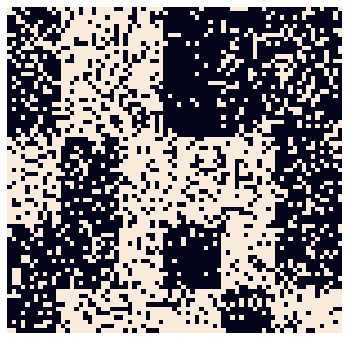

In [78]:
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [79]:
train, test = train_val_split(X, valid_dim = 0.5, random_seed= 98)

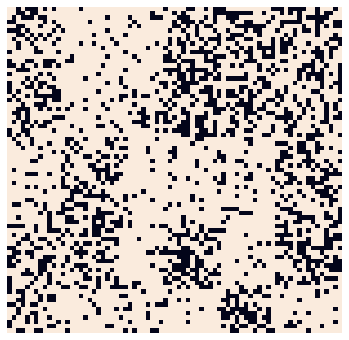

In [80]:
fig, ax = plt.subplots(figsize = (6,6))
ax = sns.heatmap(train, linewidth=0.0, ax = ax, cbar=False, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [81]:
[i/20 for i in range(5)]

[0.0, 0.05, 0.1, 0.15, 0.2]

In [92]:
missing_percents = [i/20 for i in range(11)]

config_uni = {'directed': True,
          'binary': True,
          'unicluster': True}

config_bi = {'directed': True,
          'binary': True,
          'unicluster': False}

df = pd.DataFrame(0, index = ["PY_All", "PY_Test", 'PY_bi_All', 'PY_bi_test', "GN_All", "GN_Test", 'GN_bi_All', 'GN_bi_test'], columns = [i/20 for i in range(20)])

for i, percent in enumerate(missing_percents):
    for j in [30, 98, 42, 17, 10]:
        train, test = train_val_split(X, valid_dim = percent, random_seed= j)
        mask = np.invert(test.astype('bool'))
        
        PY = SBM(config_uni, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
                start_z = "singleton", set_seed=42)
        PY.fit(train,100)
        PY.compute_block_probabilities()
        PY.predict()
        df.iloc[0,i] += np.sum(np.abs((X_gt_theta - PY.X_pred_theta)))/(len(X)*(len(X)-1))

        mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
        mask_X_pred = ma.masked_array(PY.X_pred_theta, mask = mask)
        df.iloc[1,i] += np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)
        
        PY_bi = SBM(config_bi, start_z = "singleton", set_seed=42,
         prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3,
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3)

        PY_bi.fit(train,200)
        PY_bi.compute_block_probabilities()
        PY_bi.predict()
        df.iloc[2,i] += np.sum(np.abs(X_gt_theta - PY_bi.X_pred_theta))/(len(X)*(len(X)-1))

        mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
        mask_X_pred = ma.masked_array(PY_bi.X_pred_theta, mask = mask)
        df.iloc[3,i] += np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

        GN = SBM(config_uni, prior_r = "GN", gamma_GN_r=0.45,
            start_z = "singleton", set_seed=42)
        GN.fit(train,100)
        GN.compute_block_probabilities()
        GN.predict()
        df.iloc[4,i] += np.sum(np.abs(X_gt_theta - GN.X_pred_theta))/(len(X)*(len(X)-1))

        mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
        mask_X_pred = ma.masked_array(GN.X_pred_theta, mask = mask)
        df.iloc[5,i] += np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

        GN_bi = SBM(config_bi, start_z = "singleton", set_seed=42,
         prior_r = "GN", gamma_GN_r=0.45,
         prior_c = "GN", gamma_GN_c=0.45)
        GN_bi.fit(train,200)
        GN_bi.compute_block_probabilities()
        GN_bi.predict()
        df.iloc[6,i] += np.sum(np.abs(X_gt_theta - GN_bi.X_pred_theta))/(len(X)*(len(X)-1))

        mask_X_gt = ma.masked_array(X_gt_theta, mask=mask)
        mask_X_pred = ma.masked_array(GN_bi.X_pred_theta, mask = mask)
        df.iloc[7,i] += np.sum(np.abs((mask_X_gt - mask_X_pred)))/np.sum(test)

c:\Users\nakaz\Desktop\DSBA\TESI\BNP-Net\bnpenv\lib\site-packages\pandas\core\internals\blocks.py:937: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


In [40]:
import pickle as pkl

In [58]:
with open("results/df_linkpreds_case4_1000t.pkl", "wb") as f:
    pkl.dump(df, f)

In [43]:
# with open("results/df_linkpreds_1.pkl", "rb") as f:
#     df2 = pkl.load(f)
# df2

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
PY_All,0.100034,0.142499,0.201785,0.278714,0.363199,0.462368,0.592387,0.665515,0.719829,0.792277,0.871179,0.958201,1.042577,1.127781,1.212068,1.301311,1.383833,1.472324,1.561315,1.634807
PY_Test,NaN,0.204321,0.294756,0.406765,0.522356,0.655543,0.837941,0.976294,1.093217,1.217752,1.294117,1.442786,1.579705,1.665952,1.760534,1.864890,1.940997,2.027421,2.116989,2.191340
PY_bi_All,0.100034,0.143773,0.210452,0.290692,0.387226,0.481550,0.604712,0.658264,0.706515,0.792341,0.867884,0.954787,1.041367,1.127532,1.211350,1.301341,1.383833,1.472324,1.561315,1.634807
PY_bi_test,NaN,0.208486,0.316161,0.429769,0.571573,0.702769,0.892390,1.092044,1.209611,1.327674,1.425134,1.517060,1.606693,1.687492,1.774867,1.864549,1.940997,2.027421,2.116989,2.191340
GN_All,0.100034,0.142499,0.201785,0.278714,0.363199,0.464048,0.589840,0.643729,0.719829,0.792280,0.872265,0.958498,1.042720,1.127464,1.212226,1.301288,1.383833,1.472324,1.561315,1.634807
GN_Test,NaN,0.204321,0.294756,0.406765,0.522356,0.655657,0.856378,0.922586,1.093217,1.216692,1.323974,1.457907,1.555659,1.660971,1.752538,1.864115,1.940997,2.027421,2.116989,2.191340
GN_bi_All,0.100034,0.143773,0.210452,0.290601,0.385391,0.480405,0.577391,0.680738,0.713766,0.799157,0.871997,0.954875,1.041367,1.126358,1.211350,1.301255,1.383833,1.472324,1.561218,1.634807
GN_bi_test,NaN,0.208486,0.316161,0.432625,0.565826,0.706301,0.831829,1.103629,1.210661,1.331699,1.421623,1.516921,1.606693,1.686005,1.774867,1.864643,1.940997,2.027421,2.116888,2.191340


<AxesSubplot:>

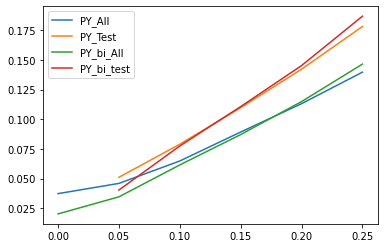

In [98]:
(df.iloc[:4,:6]/5).T.plot()

<AxesSubplot:>

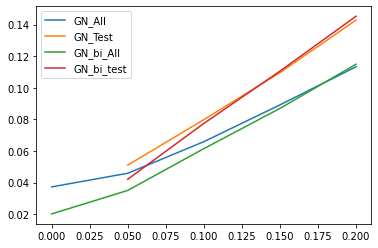

In [99]:
(df.iloc[-4:,:5]/5).T.plot()

In [93]:
df/5

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
PY_All,0.037279,0.045915,0.064818,0.089240,0.113155,0.139730,0.171025,0.204037,0.233582,0.258556,0.289537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PY_Test,NaN,0.051070,0.078971,0.109802,0.142217,0.178227,0.216601,0.258960,0.295109,0.330697,0.376671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PY_bi_All,0.020179,0.034585,0.061486,0.087105,0.114912,0.146503,0.179209,0.202646,0.239104,0.264110,0.292442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PY_bi_test,NaN,0.040314,0.077465,0.110672,0.145274,0.186894,0.229535,0.263676,0.310981,0.341970,0.381048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GN_All,0.037279,0.045915,0.065899,0.089184,0.113298,0.141173,0.170576,0.203066,0.234826,0.258875,0.284324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GN_Test,NaN,0.051070,0.079854,0.109600,0.142837,0.179613,0.215868,0.257430,0.297909,0.329685,0.366576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GN_bi_All,0.020179,0.035048,0.061486,0.086955,0.114913,0.146112,0.176088,0.204653,0.235224,0.266416,0.290142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GN_bi_test,NaN,0.042129,0.077465,0.110534,0.145285,0.186872,0.227038,0.266794,0.304765,0.343105,0.377567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for i,percent in missing_percents:
    print(i, percent)

TypeError: cannot unpack non-iterable float object